# Visualizing Global Methane Emissions in 2018

Author: **Marcin Sikorski**<br>
Date: March, 2024

**Introduction**<br>
The following notebook will visualize methane (CH<sub>4</sub>) emissions worldwide. We want to pay special attention to maintain the cartographic properties and eliminate distortions. To achieve it, we will use the `cartopy` package for base maps. This map was inspired by another map of gas emissions found on [Twitter](https://twitter.com/simongerman600/status/1696202235330412647).

Data source: [EDGAR v6.0 gridmaps](https://edgar.jrc.ec.europa.eu/gallery?release=v60ghg&substance=CH4&sector=TOTALS)


### 1. Data Import & Exploration

The data used for this notebook will be directly downloaded from the [EDGAR's website](https://edgar.jrc.ec.europa.eu/gallery?release=v60ghg&substance=CH4&sector=TOTALS). EDGAR provides a global database of anthropogenic emissions of greenhouse gases and air pollution on Earth at 0.1 x 0.1 degree resolution at global level. Each year of interest has a ZIP file containing a TXT file with geospatial data points. Unfortunately, the latest available year is 2018.

In [1]:
import pandas as pd
import urllib.request
import zipfile
import io
import matplotlib.pyplot as plt

# URL of the ZIP file
zip_url = 'https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/EDGAR/datasets/v60_GHG/CH4/TOTALS/v6.0_CH4_2018_TOTALS.zip'

# download ZIP file and create a dataframe
def read_txt_to_dataframe(zip_url):
    try:
        with urllib.request.urlopen(zip_url) as response:
            with io.BytesIO(response.read()) as zip_data:
                with zipfile.ZipFile(zip_data, 'r') as zip_ref:
                    # find the TXT file in ZIP file
                    txt_files = [f for f in zip_ref.namelist() if f.lower().endswith('.txt')]
                    # extract TXT file and read into a pandas dataframe
                    with zip_ref.open(txt_files[0]) as txt_file:
                        df = pd.read_csv(txt_file, skiprows=2, sep=';')
                        return df
                    
    except:
        print('Something went wrong.')
        return None

df = read_txt_to_dataframe(zip_url)
df = df.rename(columns={'emission 2018 (tons)': 'emission'})
df.head()

,lat,lon,emission
0,89.9,-180.0,4.791790e-04
1,89.9,-167.5,1.390110e-06
2,89.9,-167.4,1.568400e-06
3,89.9,-167.3,5.496530e-07
4,89.9,-167.2,1.262630e-06


In [2]:
# display data type and count null values for each column
df_sum = pd.DataFrame()
df_sum['feature'] = df.columns.to_list()
df_sum['nulls'] = df.isnull().sum().to_list()
df_sum.style.hide(axis='index')

feature,nulls
lat,0
lon,0
emission,0


In [3]:
print('Number of rows:', df.shape[0])
print('Min emission:', df['emission'].min())
print('Max emission:', df['emission'].max())
print('Total global emissions in 2018: {:.4f} (tons)'.format(df['emission'].sum()))

Number of rows: 4484778
Min emission: -8054.85
Max emission: 1127250.0
Total global emissions in 2018: 375337008.8258 (tons)


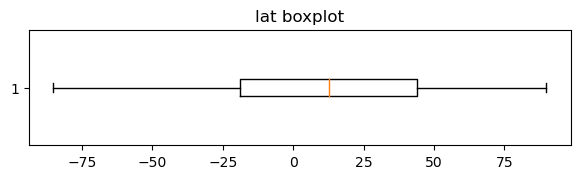

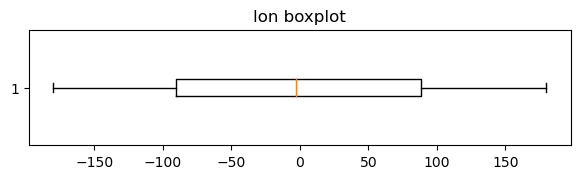

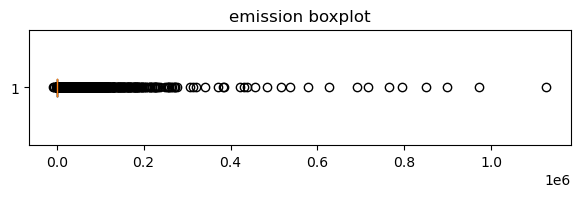

In [4]:
# check ranges with boxplots
for i in df.columns:
    plt.figure(figsize=(7, 1.5))
    plt.boxplot(df[i], vert=False)
    plt.title(i + ' boxplot')
plt.show()

In [5]:
# rows with negative emissions
df.query('`emission` < 0.0')

,lat,lon,emission
778058,53.7,-1.2,-5888.53
788763,53.4,-1.1,-8054.85
795906,53.2,-1.0,-5727.94
820854,52.5,-1.6,-2693.17


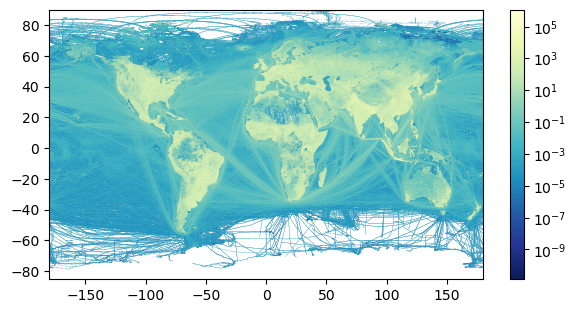

In [6]:
# filter out negative emissions
df = df[df['emission'] > 0.0]

from matplotlib.colors import LogNorm

plt.figure(figsize=(7, 3.5))
plt.margins(0) # delete margins

plt.scatter(x=df['lon'], y=df['lat'], c=df['emission'], s=0.05, alpha=1, edgecolors='none',
            norm=LogNorm(), cmap='YlGnBu_r')
plt.colorbar()
plt.show()

### 2. Generate Geospatial Dataframe

To maintain cartographic properties of our data points, we will make a geo-dataframe in `GeoPandas`. The new dataframe will contain an additional column describing its geometry. The points will be defined in the WGS84 coordinate reference system. The further plots will have data points in the Robinson map projection.

In [7]:
from geopandas import points_from_xy, GeoDataFrame

# create GeoPandas dataframe with points in WGS84 CRS
point_geometry = points_from_xy(df['lon'], df['lat'])
gdf = GeoDataFrame(data=df, crs='EPSG:4326', geometry=point_geometry)
gdf.head()

,lat,lon,emission,geometry
0,89.9,-180.0,4.791790e-04,POINT (-180.00000 89.90000)
1,89.9,-167.5,1.390110e-06,POINT (-167.50000 89.90000)
2,89.9,-167.4,1.568400e-06,POINT (-167.40000 89.90000)
3,89.9,-167.3,5.496530e-07,POINT (-167.30000 89.90000)
4,89.9,-167.2,1.262630e-06,POINT (-167.20000 89.90000)


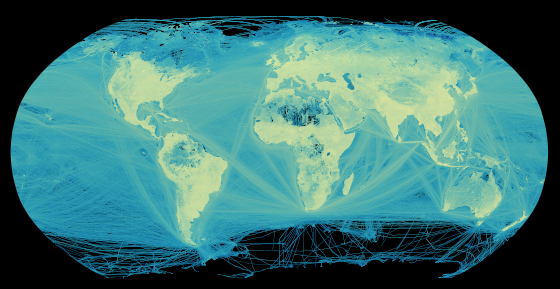

In [8]:
import cartopy.crs as ccrs

# axis, background & projection props
fig, axis = plt.subplots(facecolor='black', subplot_kw={'projection': ccrs.Robinson()})
axis.patch.set_facecolor('black')

# main plot
fig.set_size_inches(7, 3.5)
m_plot = gdf.plot(ax=axis, column=gdf['emission'], s=0.05, edgecolors='none', cmap='YlGnBu_r',
                  norm=LogNorm(), transform=ccrs.PlateCarree())

plt.setp(m_plot.spines.values(), color='black')
plt.setp([m_plot.get_xticklines(), m_plot.get_yticklines()], color='black')

m_plot.set_ylim(-8_000_000, 9_000_000)
new_axis = fig.add_axes([0.82, 0.13, 0.08, 0.08], anchor='NE')
new_axis.axis('off')

plt.show()

### 3. Create Customized Colormap

This cell will generate a custom colormap. The new colormap will have new colors defined per boundary. The bounds (expressed in tons per year) will be exactly the same as in the [reference picture](https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/EDGAR/datasets/v60_GHG/gallery/CH4/TOTALS/v6.0_CH4_2018_TOTALS.png).

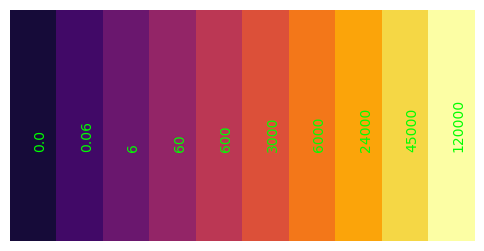

In [9]:
# disable Matplotlib warnings
import warnings
import matplotlib
warnings.filterwarnings('ignore', category=matplotlib.MatplotlibDeprecationWarning)

import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap, BoundaryNorm

custom_cmap = get_cmap('inferno', 11)
new_colors = custom_cmap(np.linspace(0, 1, 11))
custom_colors = new_colors[1:]

black = np.array([0.0, 0.0, 0.0, 1.0])
bounds = [0.0, 0.06, 6, 60, 600, 3_000, 6_000, 24_000, 45_000, 120_000]
custom_cmap = ListedColormap(custom_colors)
norm = BoundaryNorm(bounds, custom_cmap.N)

grad = np.linspace(0, 1, 10)
gradient = np.vstack((grad, grad))

# display customized colormap
plt.figure(figsize=(6, 3))
plt.imshow(gradient, aspect='auto', cmap=custom_cmap)

count = 0
for i in bounds:
    plt.text(0.0 + count, 0.7, i, color='lime', rotation='vertical')
    count += 1.0

plt.axis('off')
plt.show()

### 4. Final Map of Emissions

The final map will be based on our custom colormap. New lines of code will be added for setting a customized colorbar. We will export the final map of methane emissions as a raster-graphic.

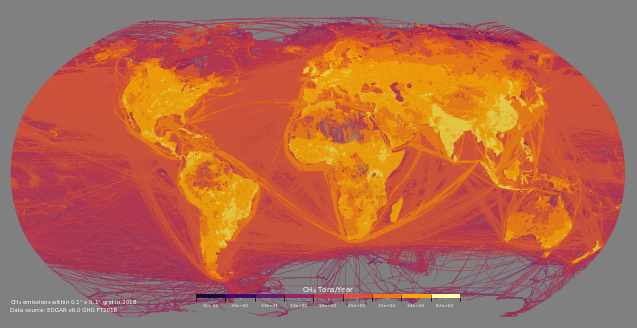

In [10]:
# final map of methane emissions
# axis, background & projection props
fig, axis = plt.subplots(facecolor='gray', subplot_kw={'projection': ccrs.Robinson()})
axis.patch.set_facecolor('gray')

# main plot
fig.set_size_inches(8, 4)
m_plot = gdf.plot(ax=axis, column=gdf['emission'], s=0.05, edgecolors='none', cmap=custom_cmap,
                  norm=LogNorm(), transform=ccrs.PlateCarree())

plt.setp(m_plot.spines.values(), color='gray')
plt.setp([m_plot.get_xticklines(), m_plot.get_yticklines()], color='gray')

m_plot.set_ylim(-8_000_000, 9_000_000)
new_axis = fig.add_axes([0.82, 0.13, 0.08, 0.08], anchor='NE')
new_axis.axis('off')
map_label = "CH$_4$ emissions within 0.1\u00b0 x 0.1\u00b0 grid in 2018\nData source: EDGAR v6.0 GHG FT2018"
descrip = m_plot.text(0.0, 0.02, s=map_label,
                      size=4,
                      color='white',
                      transform=m_plot.transAxes)

# plot colorbar
fig = m_plot.get_figure()
cax = fig.add_axes([0.36, 0.16, 0.33, 0.01])
scal_map = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
scal_map._A = []
cbar = fig.colorbar(scal_map, cax=cax, pad=0.2, format='%.1e', orientation='horizontal', drawedges=True,
                    ticks=[0.03, 3, 33, 330, 18_00, 4500, 15_000, 34_500, 82_500])
cbar.outline.set_visible(False)
# ticklabel props
cbar.ax.tick_params(labelsize=3, width=0.5, length=0.5, color='white')
cbytick_obj = plt.getp(cbar.ax, 'xticklabels')
plt.setp(cbytick_obj, color='white')
cbar.ax.set_xlabel('CH$_4$ Tons/Year', fontsize=5, labelpad=-16, color='white')

plt.savefig('ch4_map.png', dpi=600, bbox_inches='tight')

plt.show()

### 5. Conclusion

This notebook demonstrated an easy way to map where the world's methane emissions come from. The data has been collected from the official EDGAR website for the latest year 2018. The final output of this project is a map in Robinson's projection.

**References:**

1. https://edgar.jrc.ec.europa.eu/dataset_ghg80

2. https://en.wikipedia.org/wiki/Greenhouse_gas_emissions

3. https://medium.com/descarteslabs-team/sharpening-the-focus-on-methane-emissions-487f2728f072